<a href="https://colab.research.google.com/github/dmassoo/MLT_labs/blob/main/Dmitrii_Vorotnikov_J41321c__MLT_2022_Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

using gpu

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


testing speedup

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
6.81105757200001
GPU (s):
0.1346408989999901
GPU speedup over CPU: 50x


## Convolutional Neural Network 



In this notebook you will learn to distinguish dogs from cats!

Data:
https://drive.google.com/drive/folders/1nzVk4GOvKR6P87uPszUkKMPtaXV_wrZf?usp=sharing

Fill all the necessary gaps in cells below and fit neural networks for solving the binary classification task.

## Task 1:

1. Build and fit CNN with 3 convolutional layers for binary classification
2. Evaluate accuracy on test data
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)

First, let's load all the necessary functions:


In [3]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

The images collected for training and testing the deep learning model must be prepared: split the entire set into a training, validation and test sample, observing the balancing of classes (with binary classification they should be approximately equal in all three samples).

This has _already_ been done: in the Cats_and_Dogs directory there are three subdirectories: train, test and val - training, test and validation samples, respectively.

In [4]:
# if you are using google colab for this task you can mount your GoogleDrive as follows: 
from google.colab import drive
drive.mount('/content/drive/')

# After running this cell you should enter the authorization code from your Google account

Mounted at /content/drive/


In [5]:
# Initialize the folders with train, test and validation datasets (in "/My Drive/..." or from your local repository where you have downloaded data):

train = '/content/drive/MyDrive/MLT/Cats_and_Dogs/train'
val =   '/content/drive/MyDrive/MLT/Cats_and_Dogs/val'
test =  '/content/drive/MyDrive/MLT/Cats_and_Dogs/test'

# The shape of the RGB image
img_width, img_height, channels = 150, 150, 3 # you can try different sizes

# input shape
input_shape = (img_width, img_height, channels)
# position matters!
# Number_of_channels can be at the first or the last position
# in our case - "channels last"

# minibatch size
batch_size = 64
# train set size
nb_train_samples = 20000
# validation set size 
nb_validation_samples = 1000
# test set size
nb_test_samples = 1000

## Prepare the data.

You don’t have to manually change the shapes of 25000 images and convert them into the necessary format for keras (img_width, img_height, 3).

We will use the built-in image preprocessing function _ImageGenerator()_.

It performs scaling, resizes selected images and prepares batches (mini-samples) to train the model.

In [6]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
    train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

val_generator = datagen.flow_from_directory(
    val,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_generator = datagen.flow_from_directory(
    test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 2490 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
# use generator for training the model ("fit" method analog)
# model.fit_generator(
#     train_generator,
#     steps_per_epoch=nb_train_samples // batch_size,
#     epochs=10,
#     validation_data=val_generator,
#     validation_steps=nb_validation_samples // batch_size)

Set the network architecture by sequentially adding layers to it:
1. A convolutional layer with 16 neurons, filter size 3x3. Activation function - 'relu'
2. MaxPooling layer with filter size 2x2.
3. A convolutional layer with 32 neurons, filter size 3x3. Activation function - 'relu'
4. MaxPooling layer with filter size 2x2.
5. A convolutional layer with 64 neurons, filter size 3x3. Activation function - 'relu'
6. MaxPooling layer with filter size 2x2.
7. Operation model.add (Flatten ()), which makes a one-dimensional vector of the resulting feature maps.
8. A fully connected layer with 64 neurons. Activation function - 'relu'
9. Use model.add (Dropout (0.5)) which excludes the edge from the current layer in the computational graph with a 50% probability to avoid overfitting.
10. A fully connected layer with 1 neuron. Activation function - 'sigmoid', because binary classification model.

Add to the model all the missing layers, by analogy with the already specified.
Keras documentation: https://keras.io/layers/about-keras-layers/

In [ ]:
model = Sequential()

# 1: +Convolutional
# For example:
model.add(Conv2D(16, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
# 2: +Pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# 3:
model.add(Conv2D(32, (3, 3)))
#     +Relu
model.add(Activation('relu'))
# 4:  +Pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
 
# 5:  +Convolutional
model.add(Conv2D(64, (3, 3)))
#     +Relu
model.add(Activation('relu'))
# 6:  +Pooling 
model.add(MaxPooling2D(pool_size=(2, 2)))
# 7:  +Flattening
# 8:  +Dense
#     +ReLu
model.add(Flatten()) 
model.add(Dense(64, activation='relu'))
# 9:  +Dropout
# 10: +Dense
#     +Sigmoid
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# use the generator to train the model (analogue of the fit method)
# 1 epoch of training on a CPU will take 4-6 minutes. The GPU is an ~order of magnitude faster.
# THE FIRST EPOCH USUALLY TAKES MUCH LARGER TIME AS KERAS SHOULD BUILD THE COMPUTATIONAL GRAPH

model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs= 10, # try different number of epochs: 10, 15, 20; check the loss and accuracy;
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
312/312 [==============================] - 575s 2s/step - loss: 0.5913 - accuracy: 0.6751 - val_loss: 0.5034 - val_accuracy: 0.7437
Epoch 2/10
312/312 [==============================] - 499s 2s/step - loss: 0.4923 - accuracy: 0.7652 - val_loss: 0.4497 - val_accuracy: 0.7896
Epoch 3/10
312/312 [==============================] - 459s 1s/step - loss: 0.4318 - accuracy: 0.8044 - val_loss: 0.3977 - val_accuracy: 0.8240
Epoch 4/10
312/312 [==============================] - 437s 1s/step - loss: 0.3850 - accuracy: 0.8298 - val_loss: 0.3928 - val_accuracy: 0.8188
Epoch 5/10
312/312 [==============================] - 425s 1s/step - loss: 0.3476 - accuracy: 0.8467 - val_loss: 0.4090 - val_accuracy: 0.8240
Epoch 6/10
312/312 [==============================] - 420s 1s/step - loss: 0.3062 - accuracy: 0.8696 - val_loss: 0.3598 - val_accuracy: 0.8469
Epoch 7/10
312/312 [==============================] - 411s 1s/step - loss: 0.2688 - accuracy: 0.8867 - val_loss: 0.3981 - val_accuracy: 0.8406

In [ ]:
# NOTE: if the accuracy on test data after 15 epochs is less than 80% smth goes wrong

scores = model.evaluate(test_generator)
print("Accuracy on test data: %.2f%%" % (scores[1]*100))

40/40 [==============================] - 408s 10s/step - loss: 0.4125 - accuracy: 0.8572
Accuracy on test data: 85.72%


Plot the graphs: 

- Loss(Number of epochs)

- Accuracy(Number of epochs)

In [ ]:
losses = [0.5913, 0.4923, 0.4318, 0.3850, 0.3476, 0.3062, 0.2688, 0.2327, 0.1988, 0.1720]
accuracy = [0.6751, 0.7652, 0.8044, 0.8298, 0.8467, 0.8696, 0.8867, 0.8998, 0.9174, 0.9291]

In [ ]:
import matplotlib.pyplot as plt

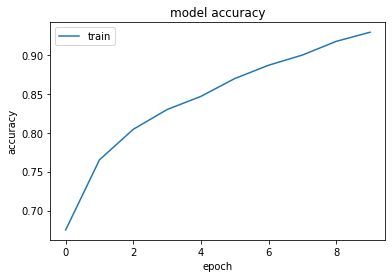

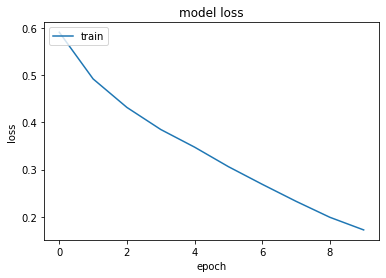

In [ ]:
plt.plot(accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

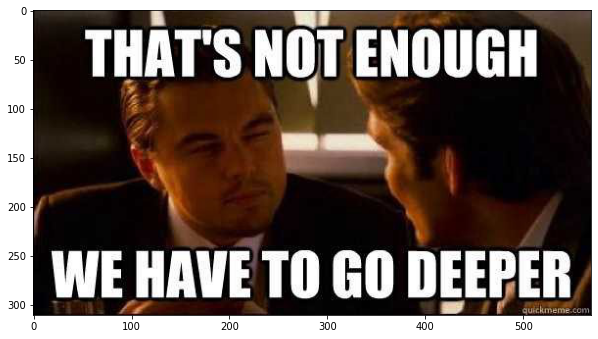

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread('/content/drive/MyDrive/Deeper.jpeg')
plt.figure(figsize = (10,20))
plt.imshow(img)
plt.show()


Let's try to improve the quality of recognition, using the method of transfer lerning. 

We will use weights of deep neural networks already trained on large dataset such as  ImageNet, and provide fine tuning of several additional dense layers on new data relevant to the current classification task. The more new images will differ from those on which the network has been trained, the more layers will need to be “retrained” in order to get good classification accuracy. The intuition here is that the model has already learned how to highlight the necessary features on the images in the large dataset, it only needs to be “tweaked” for a specific task.

## Task 2


In [7]:
# First, download the weights of the VGG16 network trained on the ImageNet dataset:

vgg16_net = VGG16(weights='imagenet', 
                  include_top=False,      # we take only the "convolution" part, the last layers we add ourselves
                  input_shape=(150, 150, 3))
vgg16_net.trainable = False               # clearly prescribe that we do NOT overload the network.
                                          # Weights VGG16 in the process of learning will remain unchanged!

vgg16_net.summary()                       # pay attention to the number of trained and untrained parameters

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

We construct our model of "transfer learning" by adding two fully connected layers to VGG16

In [8]:
# add layers to VGG16:

model2 = Sequential()
model2.add(vgg16_net)

# + flattening
model2.add(Flatten())
# + Dense fullyconnected layer with 256 neurons
# + ReLu
model2.add(Dense(256))
model2.add(Activation('relu'))
# + Dropout
model2.add(Dropout(0.5))
# + Dense layer with 1 neuron
# + sigmoid
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
 activation_1 (Activation)   (None, 1)                 0

In [9]:
model2.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


E.g., it was like:


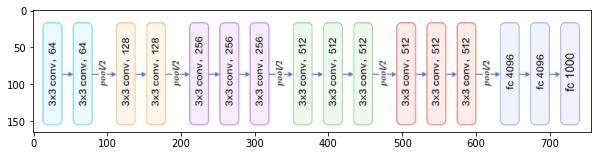

In [ ]:
img = mpimg.imread('/content/drive/MyDrive/VGG16.png')
plt.figure(figsize = (10,20))
plt.imshow(img)
plt.show()

and it becomes:

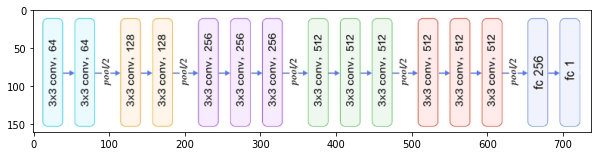

In [ ]:
img = mpimg.imread('/content/drive/MyDrive/VGG162.png')
plt.figure(figsize = (10,20))
plt.imshow(img)
plt.show()

In [11]:
# We also use the generator to train the model (similar to the fit method)
# Without using a GPU, learning 1 epoch of such a network will take about an hour. Plan your time =)
# If you have access to a GPU, you can try 10-12 epochs - the quality should increase even more.

history = model2.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
312/312 [==============================] - 2307s 7s/step - loss: 0.5081 - accuracy: 0.7410 - val_loss: 0.3448 - val_accuracy: 0.8573
Epoch 2/10
312/312 [==============================] - 249s 799ms/step - loss: 0.3413 - accuracy: 0.8518 - val_loss: 0.3047 - val_accuracy: 0.8865
Epoch 3/10
312/312 [==============================] - 196s 628ms/step - loss: 0.2969 - accuracy: 0.8742 - val_loss: 0.2723 - val_accuracy: 0.8948
Epoch 4/10
312/312 [==============================] - 165s 530ms/step - loss: 0.2744 - accuracy: 0.8847 - val_loss: 0.2578 - val_accuracy: 0.9021
Epoch 5/10
312/312 [==============================] - 151s 484ms/step - loss: 0.2593 - accuracy: 0.8912 - val_loss: 0.2489 - val_accuracy: 0.9010
Epoch 6/10
312/312 [==============================] - 138s 443ms/step - loss: 0.2467 - accuracy: 0.8962 - val_loss: 0.2338 - val_accuracy: 0.9104
Epoch 7/10
312/312 [==============================] - 137s 439ms/step - loss: 0.2367 - accuracy: 0.9013 - val_loss: 0.2386 - v

In [12]:
# Accuracy evaluation
scores = model2.evaluate(test_generator)
print("Accuracy on test data: %.2f%%" % (scores[1]*100))

40/40 [==============================] - 529s 14s/step - loss: 0.2311 - accuracy: 0.8976
Accuracy on test data: 89.76%


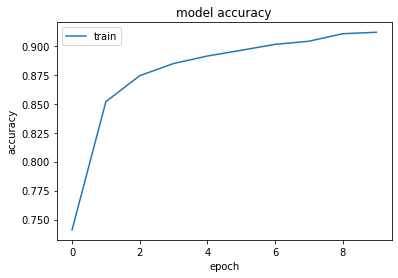

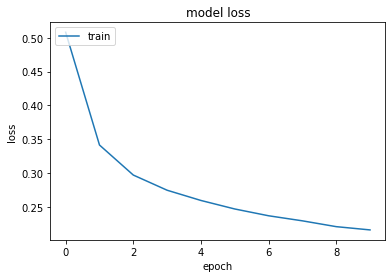

In [15]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [16]:
from keras.applications.inception_v3 import InceptionV3

In [19]:
inception_net = InceptionV3(weights='imagenet', 
                  include_top=False,      # we take only the "convolution" part, the last layers we add ourselves
                  input_shape=(150, 150, 3))
inception_net.trainable = False               # clearly prescribe that we do NOT overload the network.
                                          
inception_net.summary()   

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_22[0][0]']              
 alization)                                                                                       
                      

In [20]:
# add layers to VGG16:

model3 = Sequential()
model3.add(inception_net)

# + flattening
model3.add(Flatten())
# + Dense fullyconnected layer with 256 neurons
# + ReLu
model3.add(Dense(256))
model3.add(Activation('relu'))
# + Dropout
model3.add(Dropout(0.5))
# + Dense layer with 1 neuron
# + sigmoid
model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               4718848   
                                                                 
 activation_96 (Activation)  (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
 activation_97 (Activation)  (None, 1)                

In [21]:
model3.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5), 
              metrics=['accuracy'])

In [22]:
history2 = model3.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
312/312 [==============================] - 130s 393ms/step - loss: 0.2252 - accuracy: 0.9200 - val_loss: 0.0805 - val_accuracy: 0.9646
Epoch 2/10
312/312 [==============================] - 118s 378ms/step - loss: 0.1101 - accuracy: 0.9572 - val_loss: 0.1123 - val_accuracy: 0.9594
Epoch 3/10
312/312 [==============================] - 115s 368ms/step - loss: 0.0917 - accuracy: 0.9631 - val_loss: 0.1026 - val_accuracy: 0.9573
Epoch 4/10
312/312 [==============================] - 118s 378ms/step - loss: 0.0767 - accuracy: 0.9707 - val_loss: 0.0722 - val_accuracy: 0.9677
Epoch 5/10
312/312 [==============================] - 117s 376ms/step - loss: 0.0659 - accuracy: 0.9747 - val_loss: 0.0852 - val_accuracy: 0.9656
Epoch 6/10
312/312 [==============================] - 117s 375ms/step - loss: 0.0581 - accuracy: 0.9778 - val_loss: 0.0833 - val_accuracy: 0.9656
Epoch 7/10
312/312 [==============================] - 116s 370ms/step - loss: 0.0495 - accuracy: 0.9818 - val_loss: 0.0907 -

In [25]:
# Accuracy evaluation
scores2 = model3.evaluate(test_generator)
print("Accuracy on test data: %.2f%%" % (scores2[1]*100))

40/40 [==============================] - 17s 408ms/step - loss: 0.0947 - accuracy: 0.9644
Accuracy on test data: 96.44%


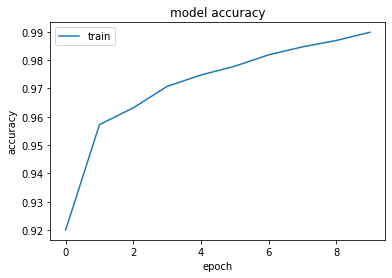

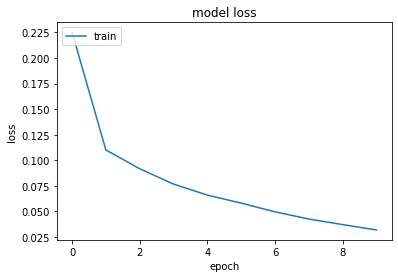

In [23]:
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

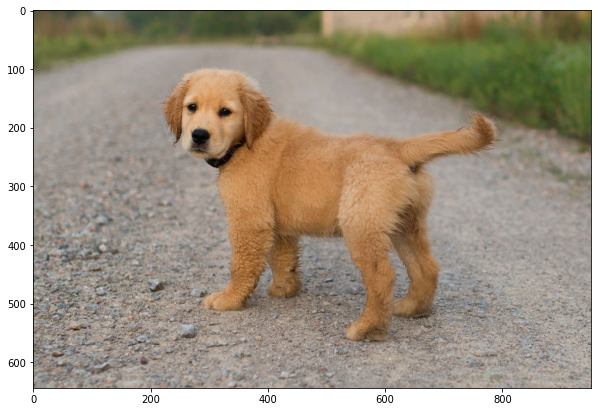

In [34]:
img_path = "/content/drive/MyDrive/MLT/Cats_and_Dogs/log/puppy-dog.jpg"
img = mpimg.imread(img_path)
plt.figure(figsize = (10,20))
plt.imshow(img)
plt.show()

In [51]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

In [50]:
image_dog = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(image_dog)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

In [55]:
model2.predict(img_preprocessed)

array([[1.]], dtype=float32)

In [54]:
model3.predict(img_preprocessed)

array([[0.01382681]], dtype=float32)